In [64]:
%pip install seaborn
import numpy as np
import scipy as sp
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 293 kB 1.7 MB/s            
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [2]:
train = pd.read_csv('/home/jupyter/mnt/s3/bank-data/data/train.csv')
bank_categories = pd.read_csv('/home/jupyter/mnt/s3/bank-data/data/bank-categories.csv')
bank_sentiment = pd.read_csv('/home/jupyter/mnt/s3/bank-data/data/bank-sentiment.csv')
banki = pd.read_csv('/home/jupyter/mnt/s3/bank-data/data/banki.csv', error_bad_lines=False, engine='python') 
sentiment = pd.read_csv('/home/jupyter/mnt/s3/bank-data/data/sentiment.csv')

Skipping line 87074: unexpected end of data


In [3]:
%pip install pymystem3 wordcloud

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


# Bank-sentiment

In [4]:
url_prefix = 'https://www.banki.ru/services/responses/bank/'

bank_sentiment['bank'] = [url.split(url_prefix)[-1][:-1] for url in list(bank_sentiment['url_bank'])]
bank_sentiment.head()

,url_bank,year,Neutral,Positive,Negative,bank
0,https://www.banki.ru/services/responses/bank/a...,2005,0.340454,0.123401,0.168461,absolutbank
1,https://www.banki.ru/services/responses/bank/a...,2006,0.470453,0.036971,0.221975,absolutbank
2,https://www.banki.ru/services/responses/bank/a...,2007,0.518411,0.095932,0.122486,absolutbank
3,https://www.banki.ru/services/responses/bank/a...,2008,0.641837,0.026239,0.172781,absolutbank
4,https://www.banki.ru/services/responses/bank/a...,2009,0.301114,0.158235,0.197596,absolutbank


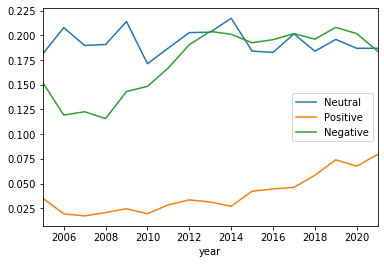

In [5]:
bank_sentiment.groupby('year')[['Neutral', 'Positive', 'Negative']].mean().plot()

In [6]:
bank_sentiment_mean = bank_sentiment.groupby('bank')[['Neutral', 'Positive', 'Negative']].mean()
bank_sentiment_mean.head()

,Neutral,Positive,Negative
bank,,,
absolutbank,0.400451,0.117421,0.276642
agropromcredit,0.152823,0.022182,0.132454
agroros,0.093478,0.195792,0.073021
akbars,0.261527,0.048595,0.310557
akcept,0.161264,0.031899,0.099474


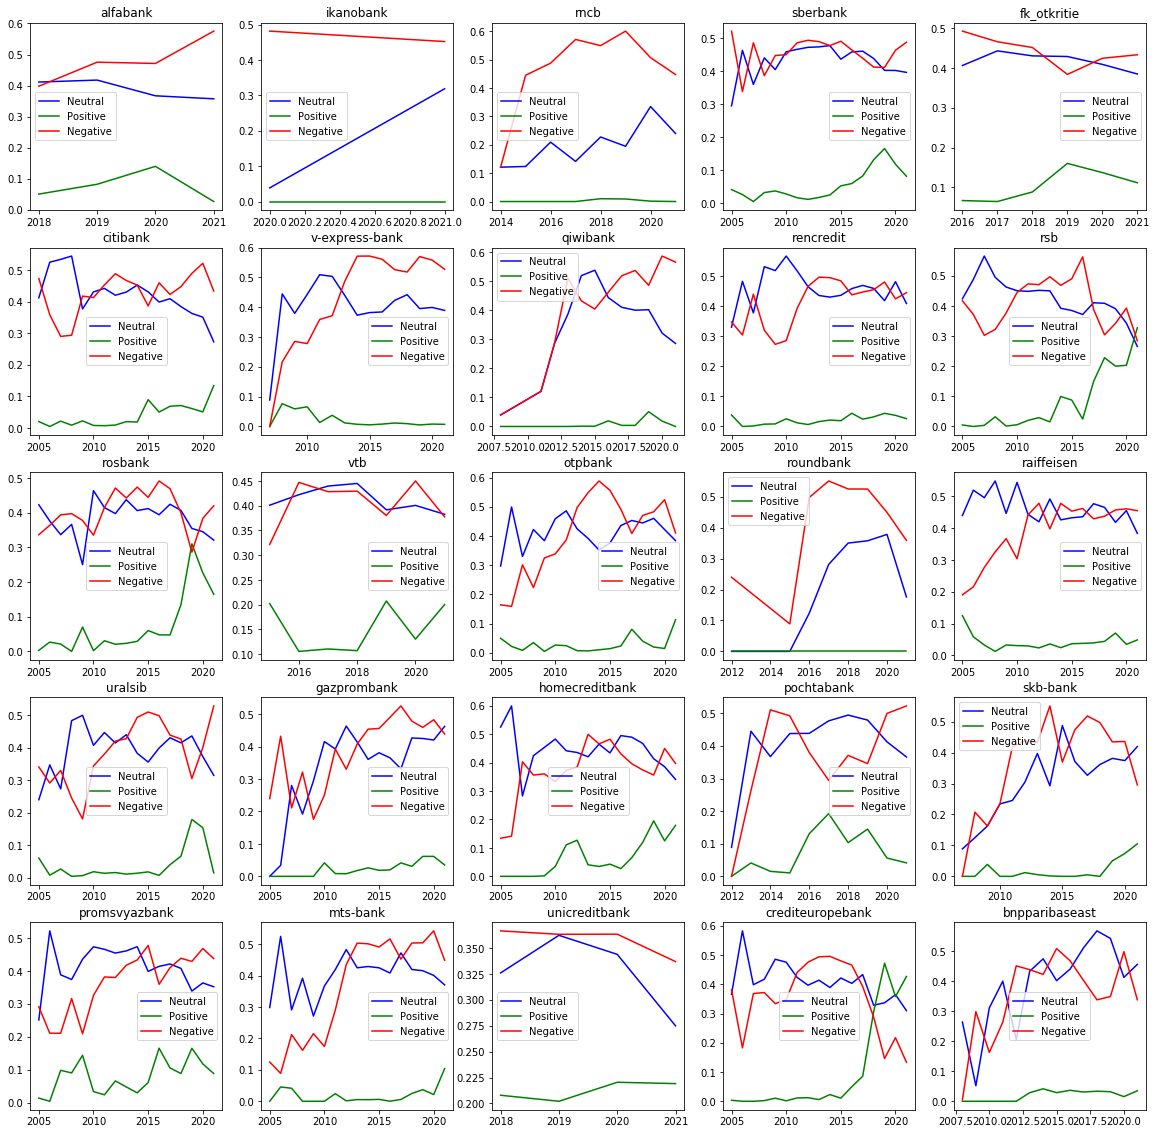

In [126]:
n_samples = 25
sentiment_class = 'Negative'
banks = list(bank_sentiment_mean[sentiment_class].nlargest(n_samples).index)

fig, ax = plt.subplots(5, 5, figsize=(20, 20))
row = 0

for i, bank in enumerate(banks):
    data = bank_sentiment[bank_sentiment['bank'] == bank]
    years = list(data['year'])
    neutral, positive, negative = list(data['Neutral']), list(data['Positive']), list(data['Negative'])
    
    ax[i // 5][i % 5].plot(years, neutral, label='Neutral', c='blue')
    ax[i // 5][i % 5].plot(years, positive, label='Positive', c='green')
    ax[i // 5][i % 5].plot(years, negative, label='Negative', c='red')
    ax[i // 5][i % 5].legend()
    ax[i // 5][i % 5].set_title(bank)
    
plt.savefig('negative_dynamics.png', bbox_inches='tight')
plt.show()

In [48]:
bank_categories.head()

,url_bank,year,Empty,Communication,Price,Quality,Safety
0,https://www.banki.ru/services/responses/bank/a...,2005,0.553188,0.057135,0.0,0.038989,0.0
1,https://www.banki.ru/services/responses/bank/a...,2006,0.645065,0.024196,0.0,0.072852,0.0
2,https://www.banki.ru/services/responses/bank/a...,2007,0.648801,0.056051,0.0,0.044448,0.0
3,https://www.banki.ru/services/responses/bank/a...,2008,0.751583,0.025834,0.0,0.072761,0.0
4,https://www.banki.ru/services/responses/bank/a...,2009,0.523015,0.032407,0.0,0.114573,0.0


# Banki

In [8]:
url_prefix = 'https://www.banki.ru/services/responses/bank/'

banki['bank'] = [url.split(url_prefix)[-1][:-1] for url in list(banki['url_bank'])]

In [9]:
sentiment.sort_values(by='ID')

,ID,sent_id,Neutral,Positive,Negative
200036,1,0,0.528878,0.004645,0.466477
200037,1,1,0.176939,0.032682,0.790379
200038,1,2,0.165811,0.003091,0.831098
200039,1,3,0.696680,0.037879,0.265441
200040,1,4,0.169959,0.038156,0.791885
...,...,...,...,...,...
3194194,488611,5,0.076966,0.006010,0.917024
3194202,488611,13,0.022239,0.003193,0.974567
3194204,488612,1,0.931664,0.014333,0.054003
3194203,488612,0,0.930920,0.012413,0.056667


# Train

## TODO: частота слов в разных классах

1/Что такое “?” в категориях. Ответ: можно считать это пропуском\
2/Что такое “?” в семантике. Ответ: нейтральный класс\
3/Что значит nan во 2 категории? Ответ: одному предложению соответствует 2 категории. Как вариант, можно вместо 1 предложения с 2 категориями сделать 2 записи с 1 предложением и 1 категорией

In [10]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from string import punctuation
from pymystem3 import Mystem

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
train['1category'] = train['1category'].replace('?', np.nan)
train.head()

,Unnamed: 0,sentence,1category,2category,sentiment
0,4754,При этом всегда получал качественные услуги.,Communication,NaN,+
1,4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",NaN,NaN,−
2,3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",NaN,NaN,−
3,11640,Отвратительное отношение к клиентам.,Communication,NaN,−
4,5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+


In [12]:
russian_stopwords = stopwords.words("russian")
translator = str.maketrans('', '', punctuation)
mystem = Mystem() 

['банк' 'сотрудник' 'клиент' 'карта' 'весь' 'очень' 'который' 'свой'
 'мочь' 'отделение' 'работа' 'вопрос' 'просто' 'работать' 'день' 'деньги'
 'спасибо' 'обслуживание' 'данный' 'отношение' 'время' 'офис' 'получать'
 'счет' 'кредит' 'проблема' 'отвечать' 'сбербанк' 'сказать' 'услуга'
 'вообще' 'человек' 'ответ' 'хотеть' 'кредитный' 'хороший' 'никто'
 'решать' 'помогать' 'ничто' 'телефон' 'говорить' 'обращаться' 'менеджер'
 'приходить' 'самый' 'банка' 'информация' 'звонить' 'сделать' 'ситуация'
 'обращение' 'пользоваться' 'документ' 'специалист' 'условие' 'знать'
 'первый' 'давать' 'звонок' 'никакой' 'решение' 'месяц' 'быстро' 'договор'
 'довольный' 'позвонить' 'полный' 'заявление' 'очередь' 'приложение'
 'почему' 'оператор' 'итог' 'банкомат' 'большой' 'заявка' 'номер' 'сумма'
 'сервис' 'рекомендовать' 'платеж' 'огромный' 'благодарность' 'должный'
 'также' 'проходить' 'оформлять' 'срок' 'каждый' 'являться' 'линия'
 'операция' 'средство' 'делать' 'закрывать' 'удобный' 'дело'
 'отвратител

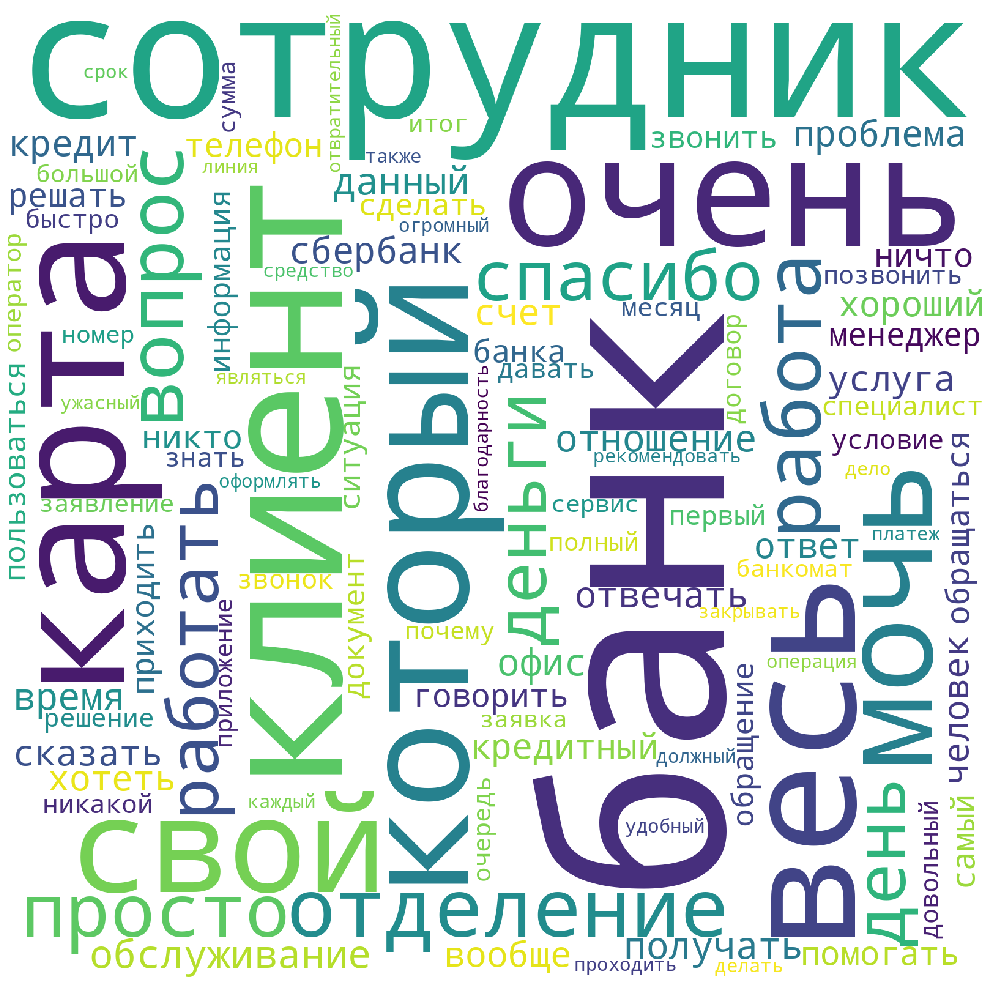

In [40]:
all_text = ' '.join(list(train['sentence'])).lower().translate(translator)

all_tokens = mystem.lemmatize(all_text)
all_tokens = [token for token in all_tokens if token not in russian_stopwords
                   and ' ' not in token 
                   and len(token) > 3]


all_tokens_unique, all_tokens_freq = np.unique(all_tokens, return_counts=True)

idxs = np.argsort(all_tokens_freq)[::-1][:100]

GARBAGE_TOKENS_SET = set(all_tokens_unique[idxs])

print(all_tokens_unique[idxs], all_tokens_freq[idxs])

wordcloud = WordCloud(width = 1600, height = 1600,
                background_color ='white',
                stopwords = russian_stopwords,
                min_font_size = 10).generate_from_frequencies({A: B for A, B in zip(all_tokens_unique[idxs], all_tokens_freq[idxs])})

fig = plt.figure(figsize=(18,18))
plt.imshow(wordcloud)
# Отключаем отображение осей
plt.axis('off')
plt.savefig('garbage.png', bbox_inches='tight')

## Group words by sentiment

In [16]:
positive_train = train[train['sentiment'] == '+']
negative_train = train[train['sentiment'] == train['sentiment'].unique()[1]]
neutral_train = train[train['sentiment'] == '?']

In [17]:
positive_text = ' '.join(list(positive_train['sentence'])).lower().translate(translator)
negative_text = ' '.join(list(negative_train['sentence'])).lower().translate(translator)
neutral_text = ' '.join(list(neutral_train['sentence'])).lower().translate(translator)

['выражать' 'приятно' 'вежливый' 'приятный' 'тинькофф' 'положительный'
 'отличный' 'впечатление' 'профессионализм' 'объяснять' 'высокий'
 'продукт' 'общение' 'грамотный' 'вклад' 'рассказывать' 'удобно'
 'отмечать' 'понравиться' 'профессиональный' 'помощь' 'уровень' 'подробно'
 'плюс' 'любой' 'оставаться' 'оперативно' 'девушка' 'оперативность'
 'доброжелательный' 'внимательный' 'хотеться' 'подход' 'оформление'
 'мобильный' 'компетентный' 'процент' 'общий' 'отдельный' 'быстрый'
 'поблагодарить' 'поддержка' 'связь' 'качественный' 'перевод' 'несколько'
 'именно' 'сразу' 'четко' 'целое' 'нравиться' 'новый' 'благодарный'
 'оплата' 'сотрудница' 'действительно' 'обслуживать' 'оперативный'
 'отлично' 'минута' 'оценка' 'вежливо' 'качество' 'желать' 'отзыв'
 'становиться' 'благодарить' 'предлагать' 'открывать' 'индивидуальный'
 'устраивать' 'особенно' 'считать' 'пока' 'прекрасный' 'принимать'
 'профессионально' 'работник' 'сайт' 'покупка' 'отдел' 'консультация'
 'момент' 'приветливый' 'спокойно' 

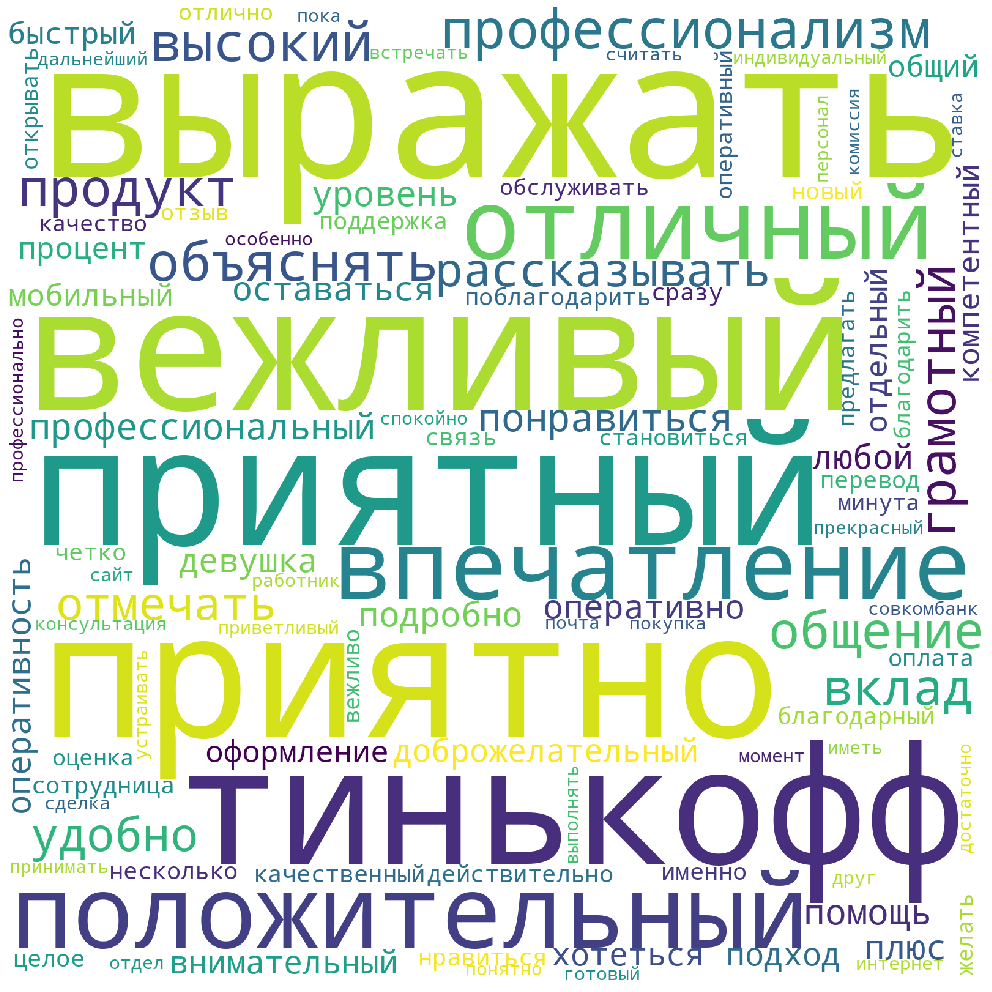

In [41]:
positive_tokens = mystem.lemmatize(positive_text)
positive_tokens = [token for token in positive_tokens if token not in russian_stopwords
                   and ' ' not in token 
                   and len(token) > 3
                   and token not in custom_stopwords]

positive_tokens_unique, positive_tokens_freq = np.unique(positive_tokens, return_counts=True)

idxs = np.argsort(positive_tokens_freq)[::-1][:100]

POSITIVE_SET = set(positive_tokens_unique[idxs])

print(positive_tokens_unique[idxs], positive_tokens_freq[idxs])

wordcloud = WordCloud(width = 1600, height = 1600,
                background_color ='white',
                stopwords = russian_stopwords,
                min_font_size = 10).generate_from_frequencies({A: B for A, B in zip(positive_tokens_unique[idxs], positive_tokens_freq[idxs])})

fig = plt.figure(figsize=(18,18))
plt.imshow(wordcloud)
# Отключаем отображение осей
plt.axis('off')
plt.savefig('positive.png', bbox_inches='tight')

['обманывать' 'невозможно' 'связываться' 'некомпетентный' 'горячий'
 'сегодня' 'отказываться' 'крайне' 'писать' 'понимать' 'написать'
 'считать' 'абсолютно' 'советовать' 'вернуть' 'обман' 'дозваниваться'
 'иметь' 'история' 'начинать' 'оказываться' 'пора' 'видеть' 'слово'
 'действие' 'становиться' 'изза' 'поддержка' 'минута' 'выдавать'
 'принимать' 'предлагать' 'сайт' 'предоставлять' 'ждать' 'рубль'
 'страховка' 'сообщать' 'руководитель' 'разбираться' 'общий' 'получаться'
 'происходить' 'просить' 'некомпетентность' 'идти' 'ошибка' 'сторона'
 'заблуждение' 'совершенно' 'вводить' 'мало' 'отдел' 'пытаться' 'нужный'
 'постоянно' 'процент' 'плохой' 'служба' 'девушка' 'хотя' 'снимать'
 'данные' 'объяснять' 'сталкиваться' 'отзыв' 'потратить' 'перезванивать'
 'результат' 'взять' 'комиссия' 'новый' 'якобы' 'лицо' 'почта'
 'отправлять' 'связь' 'заблокировать' 'система' 'возможность' 'письмо'
 'задолженность' 'продукт' 'несколько' 'рабочий' 'неделя' 'трубка' 'нужно'
 'случай' 'отказ' 'приходиться'

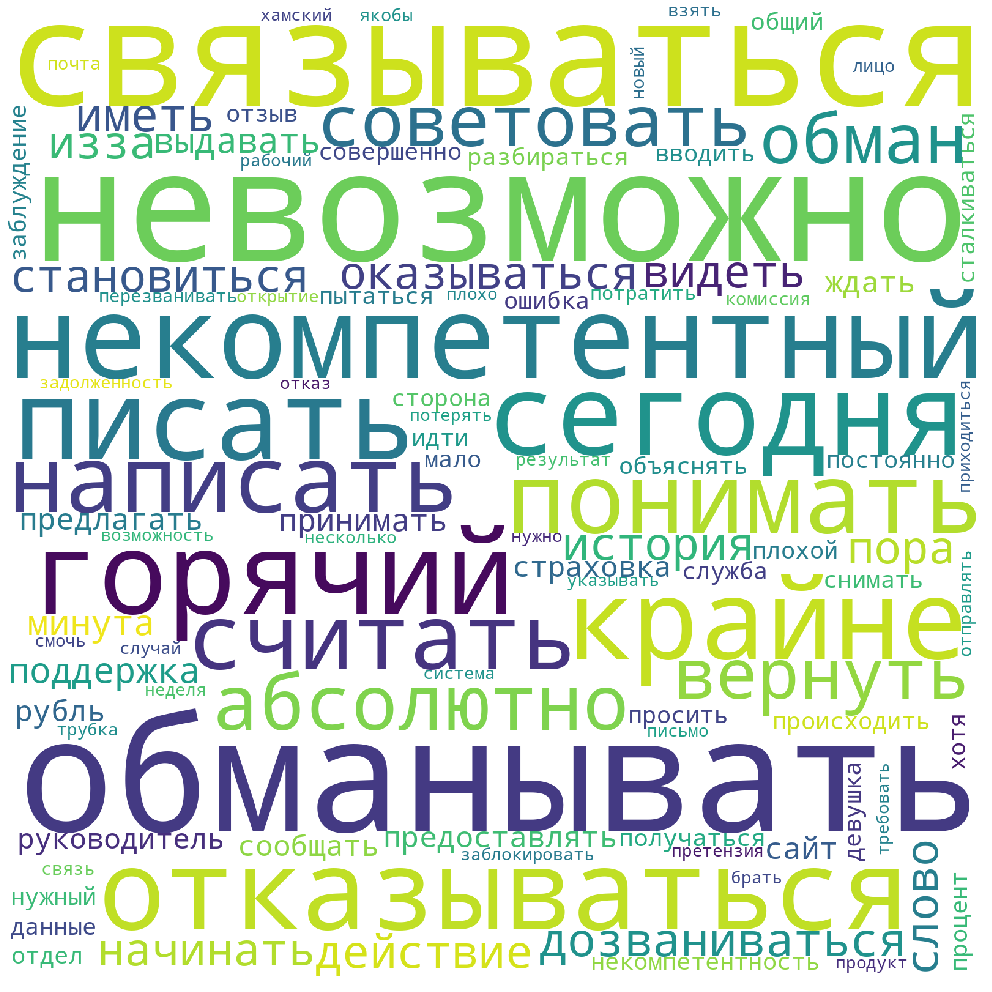

In [42]:
negative_tokens = mystem.lemmatize(negative_text)
negative_tokens = [token for token in negative_tokens if token not in russian_stopwords
                   and ' ' not in token 
                   and len(token) > 3
                   and token not in custom_stopwords]

negative_tokens_unique, negative_tokens_freq = np.unique(negative_tokens, return_counts=True)

idxs = np.argsort(negative_tokens_freq)[::-1][:100]

NEGATIVE_SET = set(negative_tokens_unique[idxs])

print(negative_tokens_unique[idxs], negative_tokens_freq[idxs])

wordcloud = WordCloud(width = 1600, height = 1600,
                background_color ='white',
                stopwords = russian_stopwords,
                min_font_size = 10).generate_from_frequencies({A: B for A, B in zip(negative_tokens_unique[idxs], negative_tokens_freq[idxs])})

fig = plt.figure(figsize=(18,18))
plt.imshow(wordcloud)
# Отключаем отображение осей
plt.axis('off')
plt.savefig('negative.png', bbox_inches='tight')

['начинать' 'выдавать' 'март' 'указывать' 'представитель' 'горячий'
 'точно' 'хотя' 'предложение' 'личный' 'находиться' 'терминал' 'проверять'
 'рабочий' 'момент' 'получение' 'акция' 'вполне' 'подавать' 'подписывать'
 'интернет' 'порядок' 'страховка' 'девушка' 'взять' 'отдел' 'продукт'
 'идти' 'встреча' 'город' '2019' 'оставаться' 'понимать' 'открытие' '2017'
 'готовый' 'полностью' 'последний' 'заранее' 'втб24' 'август' 'утро'
 'положительный' 'дополнительный' 'декабрь' 'интересный' 'рука'
 'дебетовый' 'предоставлять' 'именно' 'процент' 'проспект' 'просить'
 'ноябрь' 'филиал' 'оказываться' 'период' 'бесплатный' 'бонус' 'система'
 'сентябрь' 'исправно' 'лично' 'подключать' 'видеть' 'приходиться'
 'успешно' 'нужный' 'подходить' 'октябрь' 'начинаться' 'пока' 'курьер'
 'смочь' 'сообщение' 'квартира' 'пойти' 'улица' 'страхование' 'надеяться'
 'просрочка' 'мина' 'онлайн' 'поступать' 'письмо' 'погашение' 'добрый'
 'ждать' 'следующий' 'пополнять' 'кэшбэк' 'февраль' 'назначать' 'комиссия'
 'кон

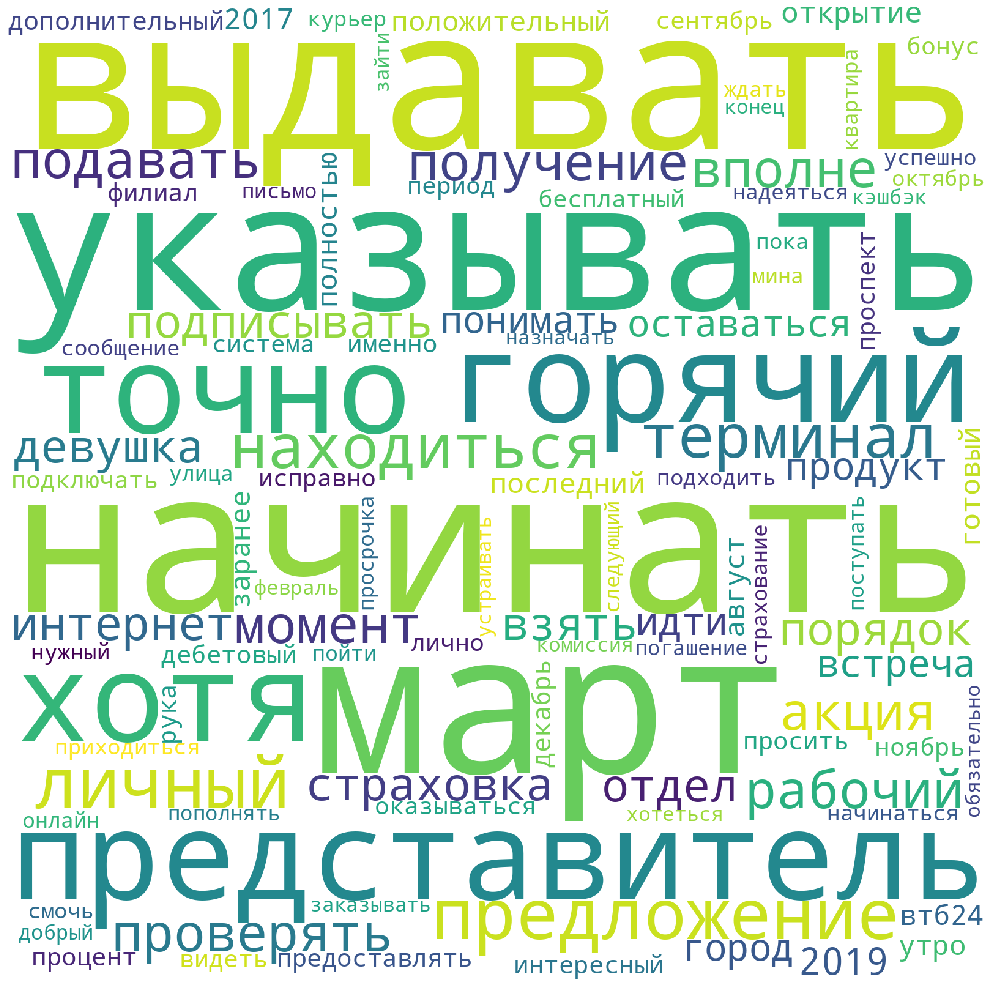

In [43]:
neutral_tokens = mystem.lemmatize(neutral_text)
neutral_tokens = [token for token in neutral_tokens if token not in russian_stopwords
                   and ' ' not in token 
                   and len(token) > 3
                   and token not in custom_stopwords]

neutral_tokens_unique, neutral_tokens_freq = np.unique(neutral_tokens, return_counts=True)

idxs = np.argsort(neutral_tokens_freq)[::-1][50:150]

NEUTRAL_SET = set(neutral_tokens_unique[idxs])

print(neutral_tokens_unique[idxs], neutral_tokens_freq[idxs])

wordcloud = WordCloud(width = 1600, height = 1600,
                background_color ='white',
                stopwords = russian_stopwords,
                min_font_size = 10).generate_from_frequencies({A: B for A, B in zip(neutral_tokens_unique[idxs], neutral_tokens_freq[idxs])})

fig = plt.figure(figsize=(18,18))
plt.imshow(wordcloud)
# Отключаем отображение осей
plt.axis('off')
plt.savefig('neutral.png', bbox_inches='tight')

In [32]:
semantic_words = {}
semantic_words['positive'] = POSITIVE_SET
semantic_words['negative'] = NEGATIVE_SET
semantic_words['neutral'] = NEUTRAL_SET

with open("semantic_words_elfat.pkl", "wb") as file:
    pickle.dump(semantic_words, file)

## Group words by class

In [33]:
communication_train = train[train['1category'] == 'Communication']
quality_train = train[train['1category'] == 'Quality']
price_train = train[train['1category'] == 'Price']
safety_train = train[train['1category'] == 'Safety']

communication_text = ' '.join(list(communication_train['sentence'])).lower().translate(translator)
quality_text = ' '.join(list(quality_train['sentence'])).lower().translate(translator)
price_text = ' '.join(list(price_train['sentence'])).lower().translate(translator)
safety_text = ' '.join(list(safety_train['sentence'])).lower().translate(translator)

['помощь' 'идти' 'сразу' 'течение' 'оформление' 'подробно' 'разбираться'
 'приятно' 'просить' 'вернуть' 'рабочий' 'письмо' 'любой' 'считать' 'лицо'
 'неделя' 'иметь' 'действие' 'хамский' 'коллцентр' 'пора' 'оказываться'
 'нужный' 'нужно' 'хотя' 'навязывать' 'работник' 'профессионализм'
 'отправлять' 'получаться' 'спрашивать' 'совершенно' 'узнавать' 'центр'
 'личный' 'видеть' 'грамотный' 'мало' 'сторона' 'происходить' 'отзыв'
 'разговор' 'вклад' 'претензия' 'история' 'постоянно' 'хамить' 'просьба'
 'предложение' 'якобы' 'оставаться' 'вежливо' 'приезжать' 'задолженность'
 'хотеться' 'некомпетентность' 'оплата' 'представитель' 'оставлять'
 'встречать' 'результат' 'тинькофф' 'выдавать' 'вести' 'брать' 'персонал'
 'именно' 'рубль' 'уровень' 'адрес' 'взять' 'называть' 'доброжелательный'
 'отмечать' 'рассмотрение' 'комиссия' 'изза' 'впечатление' 'смочь'
 'возможность' 'случай' 'мобильный' 'отказ' 'внимательный' 'приходиться'
 'хамство' 'указывать' 'обещать' 'понятно' 'разговаривать'
 'професс

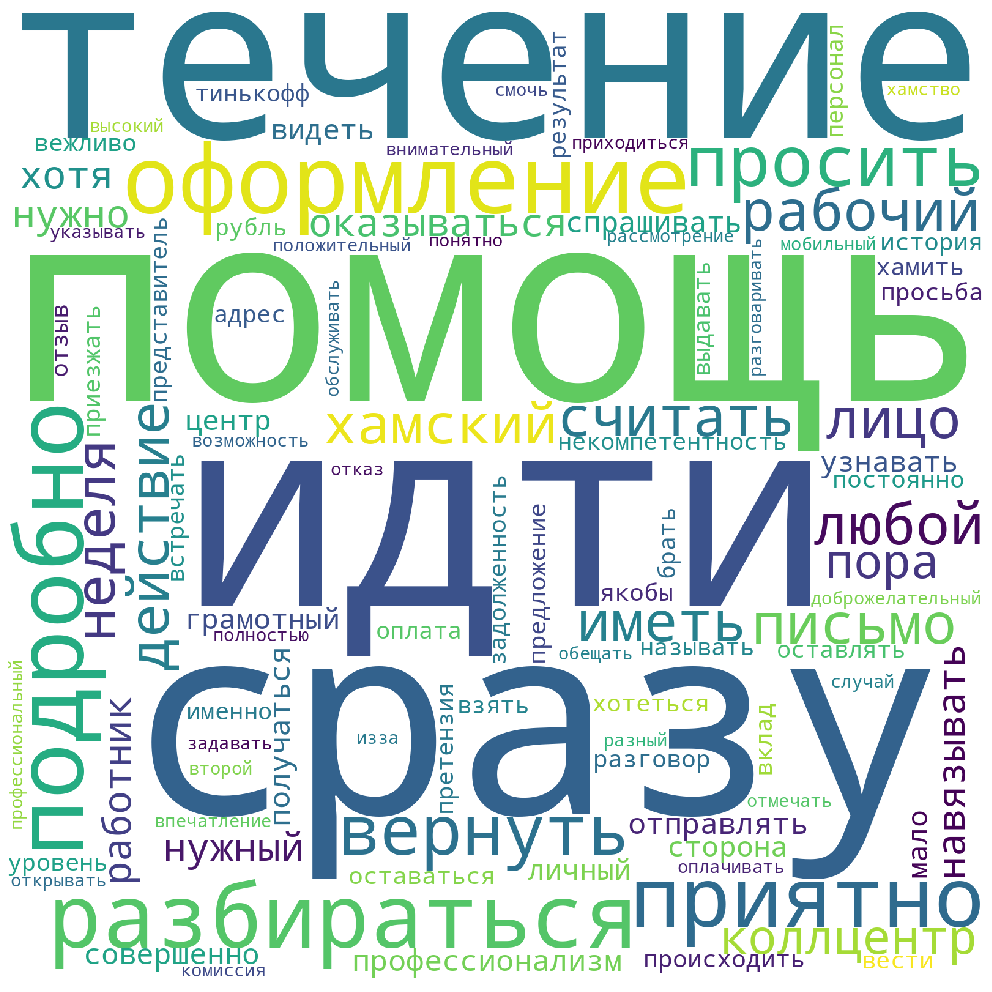

In [44]:
communication_tokens = mystem.lemmatize(communication_text)
communication_tokens = [token for token in communication_tokens if token not in russian_stopwords
                   and ' ' not in token 
                   and len(token) > 3
                   and token not in custom_stopwords]

communication_tokens_unique, communication_tokens_freq = np.unique(communication_tokens, return_counts=True)

idxs = np.argsort(communication_tokens_freq)[::-1][50:150]

COMMUNICATION_SET = set(communication_tokens_unique[idxs])

print(communication_tokens_unique[idxs], communication_tokens_freq[idxs])

wordcloud = WordCloud(width = 1600, height = 1600,
                background_color ='white',
                stopwords = russian_stopwords,
                min_font_size = 10).generate_from_frequencies({A: B for A, B in zip(communication_tokens_unique[idxs], communication_tokens_freq[idxs])})

fig = plt.figure(figsize=(18,18))
plt.imshow(wordcloud)
# Отключаем отображение осей
plt.axis('off')
plt.savefig('communication.png', bbox_inches='tight')

['сразу' 'впечатление' 'интернетбанк' 'комиссия' 'отдел' 'момент'
 'становиться' 'связь' 'пора' 'советовать' 'вежливый' 'приятный' 'рабочий'
 'поддержка' 'лицо' 'положительный' 'оформление' 'предлагать' 'отзыв'
 'мало' 'быстрый' 'понравиться' 'идти' 'терминал' 'банковский' 'денежный'
 'нравиться' 'история' 'целое' 'абсолютно' 'хотеться' 'данные'
 'происходить' 'простой' 'постоянно' 'оперативность' 'четко' 'помощь'
 'разбираться' 'открытие' 'именно' 'общий' 'личный' 'снимать' 'сторона'
 'писать' 'оперативно' 'приходиться' 'нужный' 'персонал' 'отказываться'
 'действие' 'встречать' 'девушка' 'профессиональный' 'взять' 'подход'
 'смочь' 'предоставлять' 'слово' 'приезжать' 'пока' 'плохой' 'проводить'
 'работник' 'потратить' 'некомпетентность' 'оперативный' 'возникать'
 'сбой' 'связываться' 'ипотека' 'качественный' 'отлично' 'хотя' 'потерять'
 'место' 'москва' 'кабинет' 'действительно' 'ожидание' 'подходить'
 'грамотный' 'обслуживать' 'полностью' 'отсутствие' 'платить' 'нужно'
 'объяснять' '

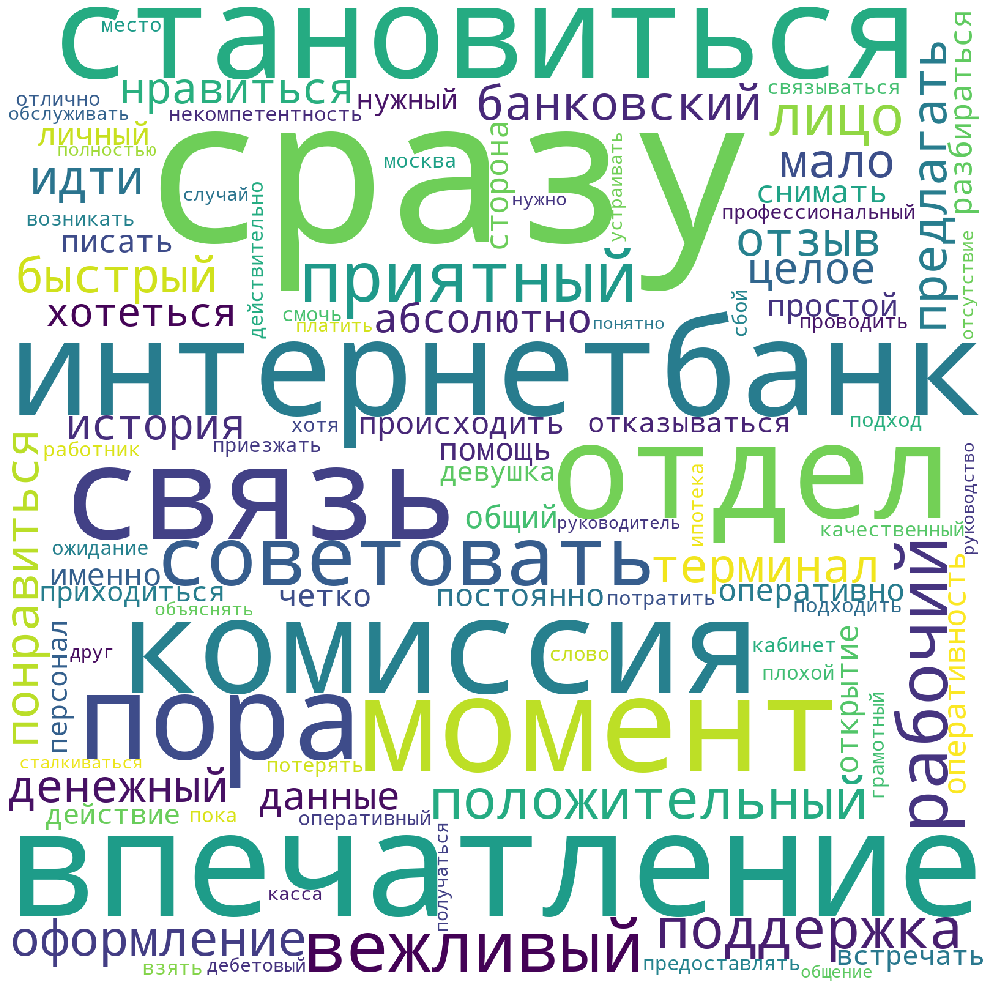

In [45]:
quality_tokens = mystem.lemmatize(quality_text)
quality_tokens = [token for token in quality_tokens if token not in russian_stopwords
                   and ' ' not in token 
                   and len(token) > 3
                   and token not in custom_stopwords]

quality_tokens_unique, quality_tokens_freq = np.unique(quality_tokens, return_counts=True)

idxs = np.argsort(quality_tokens_freq)[::-1][50:150]

QUALITY_SET = set(quality_tokens_unique[idxs])

print(quality_tokens_unique[idxs], quality_tokens_freq[idxs])

wordcloud = WordCloud(width = 1600, height = 1600,
                background_color ='white',
                stopwords = russian_stopwords,
                min_font_size = 10).generate_from_frequencies({A: B for A, B in zip(quality_tokens_unique[idxs], quality_tokens_freq[idxs])})

fig = plt.figure(figsize=(18,18))
plt.imshow(wordcloud)
# Отключаем отображение осей
plt.axis('off')
plt.savefig('quality.png', bbox_inches='tight')

['процент' 'ставка' 'рубль' 'комиссия' 'вклад' 'выгодный' 'бесплатный'
 'покупка' 'тариф' 'остаток' 'любой' 'снимать' 'плюс' 'вернуть'
 'предлагать' 'бесплатно' 'предложение' 'курс' 'кэшбэк' 'оказываться'
 'высокий' 'платить' 'валюта' 'считать' 'бонус' 'дебетовый' 'мало'
 'открывать' 'нужный' 'отличный' 'привлекательный' 'возможность' 'брать'
 'перевод' 'одобрять' 'снятие' 'акция' 'переводить' 'течение'
 'грабительский' 'магазин' 'годовой' 'ипотека' 'кредитование' 'приемлемый'
 'заплатить' 'халва' 'нравиться' 'учет' 'удобно' 'оплата' 'изза' 'момент'
 'продукт' 'программа' 'кешбек' 'оплачивать' 'страховка' 'повышенный'
 'партнер' 'начислять' 'многий' 'приятный' 'почта' 'крайне' 'процентный'
 'взять' '3000' 'рассчитывать' 'немного' 'билет' 'сложно' 'абсолютно'
 'устраивать' 'тинька' 'образ' 'заблокировать' 'категория' 'рублевый'
 '1000' 'несколько' 'интересный' 'причем' 'система' 'приятно'
 'пользование' 'альфа' 'низкий' 'сколько' 'часть' 'скорость' 'депозит'
 'стоять' 'оформление' 'элек

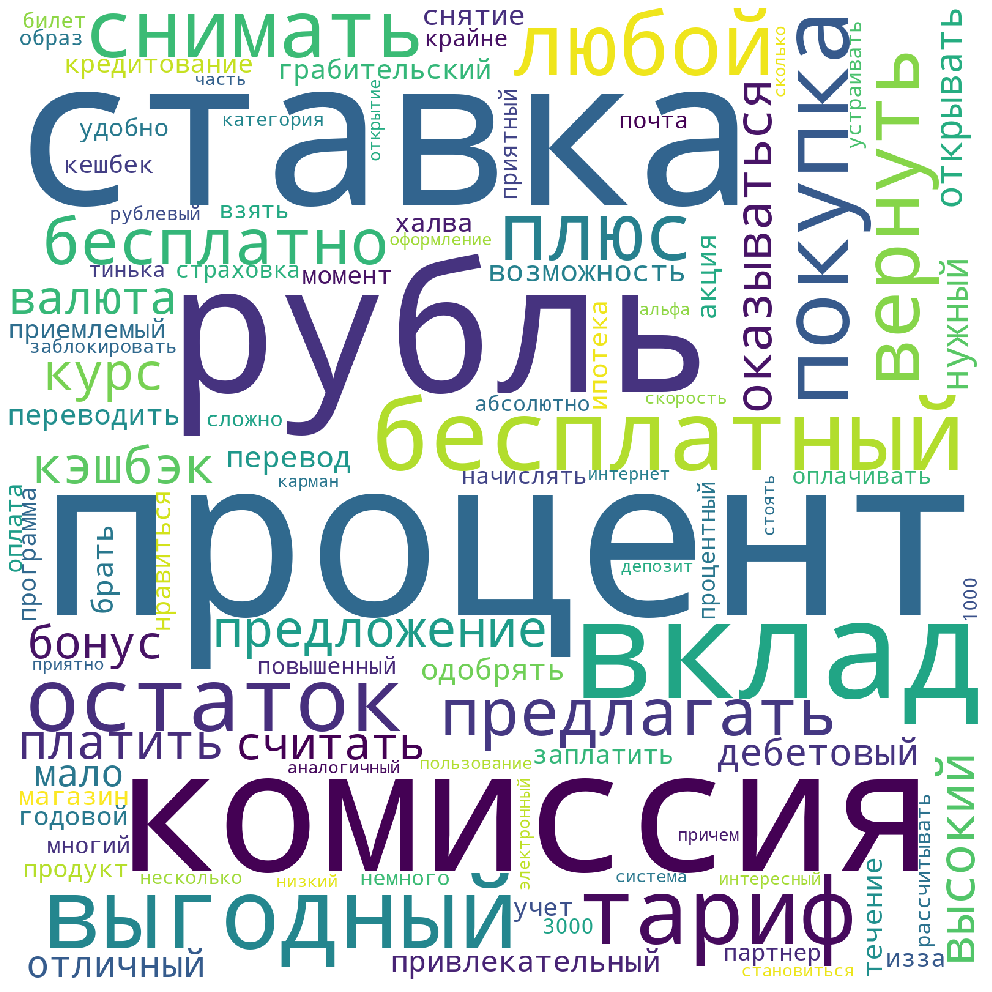

In [46]:
price_tokens = mystem.lemmatize(price_text)
price_tokens = [token for token in price_tokens if token not in russian_stopwords
                   and ' ' not in token 
                   and len(token) > 3
                   and token not in custom_stopwords]

price_tokens_unique, price_tokens_freq = np.unique(price_tokens, return_counts=True)

idxs = np.argsort(price_tokens_freq)[::-1][:100]

PRICE_SET = set(price_tokens_unique[idxs])

print(price_tokens_unique[idxs], price_tokens_freq[idxs])

wordcloud = WordCloud(width = 1600, height = 1600,
                background_color ='white',
                stopwords = russian_stopwords,
                min_font_size = 10).generate_from_frequencies({A: B for A, B in zip(price_tokens_unique[idxs], price_tokens_freq[idxs])})

fig = plt.figure(figsize=(18,18))
plt.imshow(wordcloud)
# Отключаем отображение осей
plt.axis('off')
plt.savefig('price.png', bbox_inches='tight')

['иметь' 'обманывать' 'служба' 'просить' 'случай' 'начинать' 'поступать'
 'рубль' 'согласие' 'россия' 'история' 'право' 'снимать' 'закон'
 'становиться' 'мошеннический' 'задолженность' 'получаться' 'считать'
 'банковский' 'требовать' 'трубка' 'видеть' 'предлагать' 'родственник'
 'указывать' 'предоставлять' 'вносить' 'платить' 'написать' 'обработка'
 'образ' 'проверка' 'долг' 'проводить' 'сообщать' 'абсолютно' 'поддельный'
 'нарушение' 'момент' 'разговор' 'обманный' 'разглашать' 'защита' 'отдел'
 'слово' 'названивать' 'заблокировать' 'незаконный' 'система' 'тинькофф'
 'общаться' 'мурат' 'денежный' 'начинаться' 'лицо' 'передавать' 'родитель'
 'проверять' 'плохо' 'совершать' 'понимать' 'иметься' 'противный'
 'альфабанк' 'совершенно' 'знакомый' 'перевести' 'обман' 'справка' 'тайна'
 'происходить' 'друг' 'именно' 'выезд' 'выдавать' 'орган' 'потенциальный'
 'несколько' 'плохой' 'крупный' 'горячий' 'видимо' 'незнакомый'
 'дебетовый' 'мобильный' '1500' 'угрожать' 'заемщик' 'место' 'позволять'


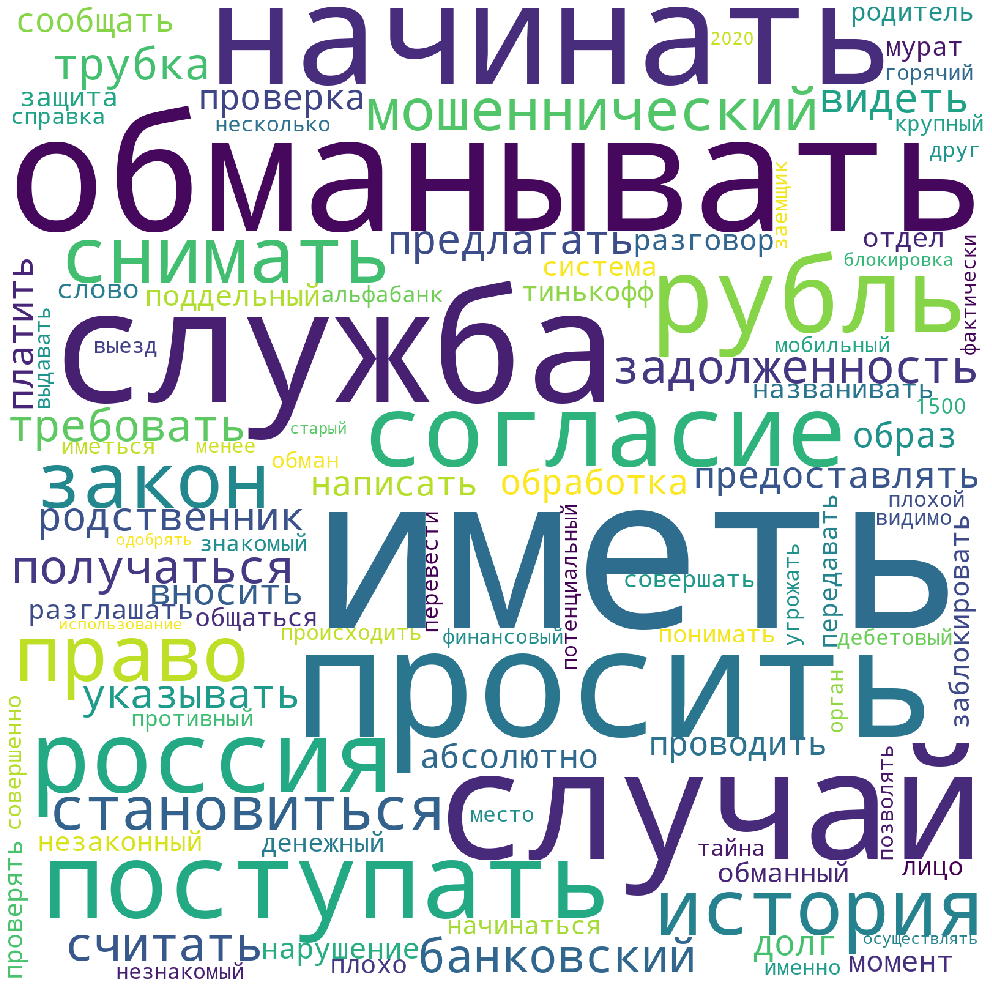

In [47]:
safety_tokens = mystem.lemmatize(safety_text)
safety_tokens = [token for token in safety_tokens if token not in russian_stopwords
                   and ' ' not in token 
                   and len(token) > 3
                   and token not in custom_stopwords]

safety_tokens_unique, safety_tokens_freq = np.unique(safety_tokens, return_counts=True)

idxs = np.argsort(safety_tokens_freq)[::-1][5:105]

SAFETY_SET = set(safety_tokens_unique[idxs])

print(safety_tokens_unique[idxs], safety_tokens_freq[idxs])

wordcloud = WordCloud(width = 1600, height = 1600,
                background_color ='white',
                stopwords = russian_stopwords,
                min_font_size = 10).generate_from_frequencies({A: B for A, B in zip(safety_tokens_unique[idxs], safety_tokens_freq[idxs])})

fig = plt.figure(figsize=(18,18))
plt.imshow(wordcloud)
# Отключаем отображение осей
plt.axis('off')
plt.savefig('safety.png', bbox_inches='tight')

In [38]:
category_words = {}
category_words['communication'] = COMMUNICATION_SET
category_words['quality'] = QUALITY_SET
category_words['price'] = PRICE_SET
category_words['safety'] = SAFETY_SET

with open("category_words_elfat.pkl", "wb") as file:
    pickle.dump(category_words, file)

# Pipeline

In [106]:
def preprocess_text(text):
    mystem = Mystem() 
    text = text.lower().translate(translator)
    tokens = mystem.lemmatize(text)
    tokens = [token for token in tokens if token not in russian_stopwords
               and ' ' not in token]
    return tokens

In [107]:
def jaccard_index(a, b):
    a = set(a)
    b = set(b)
    return len(a.intersection(b)) / len(a.union(b))

In [108]:
n = 0
jaccard_index(preprocess_text(train.iloc[n]['sentence']), POSITIVE_SET), jaccard_index(preprocess_text(train.iloc[n]['sentence']), NEGATIVE_SET)

(0.009615384615384616, 0.0)

In [115]:
'''
ВАЖНО!!! Обработка токенов
'''

all_sentences_text = ' SEPARATION '.join(list(train['sentence']))
all_sentences_tokens = preprocess_text(all_sentences_text)

all_sentences = []
buf_sentence = []

for i, token in enumerate(all_sentences_tokens):
    if token == 'separation':
        all_sentences.append(buf_sentence)
        buf_sentence = []
    elif i == len(all_sentences_tokens) - 1:
        all_sentences.append(buf_sentence)
        buf_sentence = []
    else:
        buf_sentence.append(token)

In [116]:
from tqdm import tqdm


jaccard_positive = []
jaccard_negaitive = []
jaccard_neutral = []

jaccard_communication = []
jaccard_quality = []
jaccard_price = []
jaccard_safety = []

for tokens in tqdm(all_sentences):
    jaccard_positive.append(jaccard_index(tokens, POSITIVE_SET))
    jaccard_negaitive.append(jaccard_index(tokens, NEGATIVE_SET))
    jaccard_neutral.append(jaccard_index(tokens, NEUTRAL_SET))
    
    jaccard_communication.append(jaccard_index(tokens, COMMUNICATION_SET))
    jaccard_quality.append(jaccard_index(tokens, QUALITY_SET))
    jaccard_price.append(jaccard_index(tokens, PRICE_SET))
    jaccard_safety.append(jaccard_index(tokens, SAFETY_SET))

100%|██████████| 19361/19361 [00:00<00:00, 24122.24it/s]


In [120]:
train['jaccard_positive'] = jaccard_positive
train['jaccard_negative'] = jaccard_negaitive
train['jaccard_neutral'] = jaccard_neutral

train['jaccard_communication'] = jaccard_communication
train['jaccard_quality'] = jaccard_quality
train['jaccard_price'] = jaccard_price
train['jaccard_safety'] = jaccard_safety

In [125]:
train.to_csv('/home/jupyter/mnt/s3/bank-data/features/train_jaccard_elfat.csv')

## Test

#  Связь Эмоций и Темы

In [52]:
train.head()

,Unnamed: 0,sentence,1category,2category,sentiment
0,4754,При этом всегда получал качественные услуги.,Communication,NaN,+
1,4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",NaN,NaN,−
2,3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",NaN,NaN,−
3,11640,Отвратительное отношение к клиентам.,Communication,NaN,−
4,5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+


In [53]:
train['1category'].unique()

array(['Communication', nan, 'Quality', 'Price', 'Safety'], dtype=object)

In [54]:
train['sentiment'].unique()

array(['+', '−', '?'], dtype=object)

In [55]:
train[(train['1category'] == 'Communication') & (train['sentiment'] == '+')].count()[0]

2278

In [56]:
pairwise_freq = {}
for cat in ['Communication', 'Quality', 'Price', 'Safety']:
    cat_freq = {}
    for sent in ['+', '−', '?']:
        cat_freq[sent] = train[(train['1category'] == cat) & (train['sentiment'] == sent)].count()[0]
    pairwise_freq[cat] = cat_freq

In [68]:
pairwise_freq_df = pd.DataFrame(pairwise_freq)
pairwise_freq_df

,Communication,Quality,Price,Safety
+,2278,2429,214,24
−,4589,3000,128,204
?,326,201,24,18


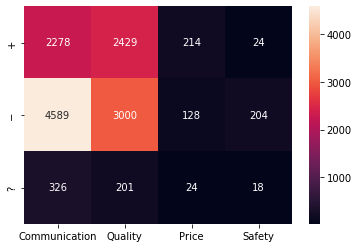

In [79]:
correlation_heatmap = sns.heatmap(pairwise_freq_df, annot=True, fmt='g')
fig = correlation_heatmap.get_figure()
fig.savefig("heatmap_full.png", bbox_inches='tight') 

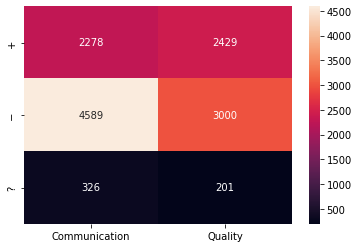

In [80]:
correlation_heatmap = sns.heatmap(pairwise_freq_df[['Communication', 'Quality']], annot=True, fmt='g')
fig = correlation_heatmap.get_figure()
fig.savefig("heatmap_1.png", bbox_inches='tight') 

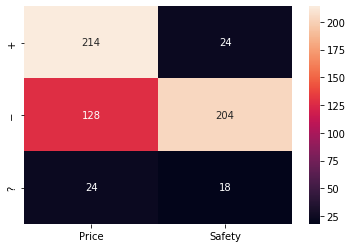

In [81]:
correlation_heatmap = sns.heatmap(pairwise_freq_df[['Price', 'Safety']], annot=True, fmt='g')
fig = correlation_heatmap.get_figure()
fig.savefig("heatmap_2.png", bbox_inches='tight') 